In [41]:
import argparse
import os
import pickle

import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.gridspec as gridspec
from kmeans_pytorch import kmeans
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from rtpt import RTPT
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from torch.nn import DataParallel as DP
from torch.utils.data import DataLoader
from torchvision.transforms.functional import rgb_to_grayscale
from tqdm import tqdm

from sysbinder.data import GlobDataset
from data import CLEVREasyWithAnnotations
from sysbinder.sysbinder import SysBinderImageAutoEncoder
from sysbinder.utils import set_seed
from sysbindretriever import NeuralConceptBinder, NonLinClassifier
import utils_bnr as utils_bnr


class Args:
    seed = 0
    batch_size = 1
    num_workers = 4
    image_size = 128
    image_channels = 3

    checkpoint_path = "logs/sysbind_orig_seed0/best_model.pt"
#     data_path = "/Users/ml-wstammer/Documents/PhD/datasets/clevr-easy-1-small/"
#     data_path = "/Users/ml-wstammer/Documents/PhD/datasets/clevr-easy/**/*.png"
    data_path = "/Users/ml-wstammer/Documents/PhD/datasets/CLEVR-Easy-1-old/"
    log_path = "logs/"

    lr_dvae = 3e-4
    lr_enc = 1e-4
    lr_dec = 3e-4
    lr_warmup_steps = 30000
    lr_half_life = 250000
    clip = 0.05
    epochs = 1 
    num_iterations = 3
    num_slots = 4
    num_blocks = 8
    cnn_hidden_size = 512
    slot_size = 2048
    mlp_hidden_size = 192
    num_prototypes = 64
    temp = 1.
    temp_step = False

    vocab_size = 4096
    num_decoder_layers = 8
    num_decoder_heads = 4
    d_model = 192
    dropout = 0.1

    tau_start = 1.0
    tau_final = 0.1
    tau_steps = 30000

    use_dp = False

    # arguments for clustering
    cluster_type = 'kmeans'
    num_clusters = 12
    num_show_per_cluster = 20

args=Args()
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(args.seed)

args.log_dir = os.path.join(*args.checkpoint_path.split(os.path.sep)[:-1])

# set seed
torch.manual_seed(args.seed)

THRESH_OBJ_IN_SLOT = 0.98 # found heuristically/visually
THRESH_ATTN = 0.8 # found heuristically/visually

In [2]:
# load model (from checkpoint)    
model = SysBinderImageAutoEncoder(args)

if os.path.isfile(args.checkpoint_path):
    checkpoint = torch.load(args.checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint)
    args.log_dir = os.path.join(*args.checkpoint_path.split(os.path.sep)[:-1])
    print("Model loaded.")
else:
    print("Model path was not found.")

model = model.to(args.device)
if args.use_dp:
    model = DP(model)

model.eval()
print("")

/Users/ml-wstammer/Documents/PhD/python3.9-sbr/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model loaded.



In [42]:
# get all train data
train_dataset = CLEVREasyWithAnnotations(
    root=args.data_path, phase="train", img_size=args.image_size, max_num_objs=args.num_slots,
    label_type="dt", num_categories=2,
)
test_dataset = CLEVREasyWithAnnotations(
    root=args.data_path, phase="test", img_size=args.image_size, max_num_objs=args.num_slots,
    label_type="dt", num_categories=2,
)

loader_kwargs = {
    "batch_size": args.batch_size,
    "shuffle": True,
    "num_workers": args.num_workers,
    "pin_memory": True,
    "drop_last": True,
}
train_loader = DataLoader(train_dataset, **loader_kwargs)
loader_kwargs = {
    "batch_size": args.batch_size,
    "shuffle": False,
    "num_workers": args.num_workers,
    "pin_memory": True,
    "drop_last": True,
}
test_loader = DataLoader(test_dataset, **loader_kwargs)

print("Data loaded")

Data loaded


In [68]:
def get_next_sample_and_encs(model, loader, args):
    sample = next(iter(loader))

    if '-1' in args.data_path:
        imgs, _, annotations, _, class_labels, _ = map(lambda x: x.to(args.device), sample)
    elif 'clevr-easy/' in args.data_path:
        imgs = sample.to(args.device)

        
    # encode image 
    encs = model.encode(imgs)

    assert imgs.shape[0] == 1 
    assert encs[0].shape[0] == 1

    img = imgs[0]
    slots = encs[0][0].detach().cpu().numpy()
    attns_vis = encs[1][0].detach().cpu().numpy()
    attns = encs[2][0].detach().cpu().numpy()
    
    return img, slots, attns_vis, attns


def transform_np_slots_to_torch_slots(np_slots, args):
    slots = torch.tensor(np_slots).to(args.device)
    return slots.unsqueeze(0)


def torch_img_to_np_img(torch_img):
    assert torch_img.shape[0] == 1
    img = torch_img[0].detach().cpu().numpy()
    return np.transpose(img, (1, 2, 0))


def find_slot_id_with_obj(attns, args):
    '''
    This function returns the index of the slot that most likely contains the object. 
    Important: we herefore assume that in fact only one object is present in the image such that we can 
    filter the slot attention masks by finding that slot which contains the most attention values above a 
    heuristically set threshold. This slot most likely contain the one object of the image.
    
    in:
    attns: [n_slots, 1, w_img, h_img], numpy array, attention masks for each slot. 
            These attention values should be between 0 and 1.
    out:
    obj_slot_id: int scalar, between 0 and args.num_slots, indicates which slot id contains the object slot
    '''
    assert np.max(attns) <= 1. and np.min(attns) >= 0.
    assert type(attns) is np.ndarray
    counts = [np.sum(attns[i] >= THRESH_OBJ_IN_SLOT) for i in range(args.num_slots)]
    obj_slot_id = np.argmax(counts)
    return obj_slot_id


def plot_img_and_attns(img, attns_vis, attns):
    fig, axs = plt.subplots(2, 3)
    axs = axs.flatten()
    axs[0].imshow(np.transpose(img, (1, 2, 0)))
    axs[0].axis('off')
    for i in range(0, 4):
        axs[i+1].imshow(np.transpose(attns[i], (1, 2, 0)))
        axs[i+1].axis('off')
    axs[-1].axis('off')

    
def thresh_attns(attns_np):
    attns_thresh = np.copy(attns_np)
    attns_thresh[attns_np < THRESH_ATTN] = 0.
    attns_thresh[attns_np >= THRESH_ATTN] = 1.
    return attns_thresh


def get_block_by_id(slot, block_id, args):
    '''
    Grab the specific block from a given slot.
    '''
    # make sure slot is just 1D individual slot
    assert len(slot.shape) == 1
    block_size = args.slot_size // args.num_blocks
    
    block = slot[block_id * block_size : (block_id + 1) * block_size]
    
    return block

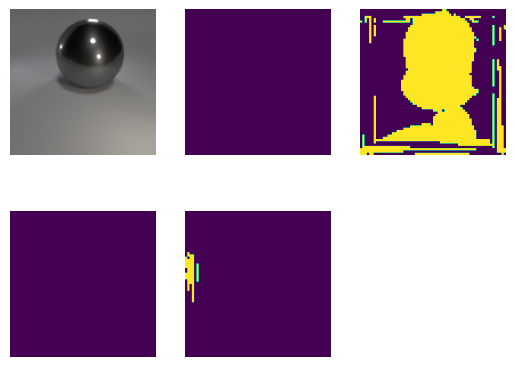

In [43]:
img1, slots1, attns_vis1, attns1 = get_next_sample_and_encs(model, train_loader, args)
attns1_thresh = thresh_attns(attns1)
plot_img_and_attns(img1, attns_vis1, attns1_thresh)
# plot_hists(attns1)
obj_slot_id1 = find_slot_id_with_obj(attns1, args)

In [44]:
with open("tmp/block_concept_dicts", "rb") as handle:   #Pickling
    block_concept_dicts = pickle.load(handle)

In [88]:
# prototype_slots = np.copy(slots1)
# tmp_slot = []
# for block_id in range(args.num_blocks):
# #     # choose a random cluster id
# #     cluster_id = np.random.randint(0, len(block_concept_dicts[block_id]['prototypes']['prototypes']))
#     cluster_id = 0
#     tmp_slot.append(block_concept_dicts[block_id]['prototypes']['prototypes'][cluster_id])
# prototype_slots[obj_slot_id1] = np.concatenate(tmp_slot).shape
# prototype_slots[obj_slot_id1] = slots1[obj_slot_id1]

prototype_slots_block = []

block_id = 7
n_cluster = len(block_concept_dicts[block_id]['prototypes']['prototypes'])
for cluster_id in range(n_cluster):
    prototype_slots = np.copy(slots1)

    # grab block from base slot
    tmp_block = get_block_by_id(slots1[obj_slot_id1], block_id, args) 
    # replace this block with the copy of the new block slot
    tmp_block[:] = np.copy(block_concept_dicts[block_id]['prototypes']['prototypes'][cluster_id])
    
    prototype_slots_block.append(prototype_slots)

In [89]:
# out1 = model.decode(transform_np_slots_to_torch_slots(slots1, args))

out_prototypes_block = []
for cluster_id in range(n_cluster):
    out_prototypes_block.append(
        model.decode(
            transform_np_slots_to_torch_slots(
                prototype_slots_block[cluster_id], 
                args
            )
        )
    )
    print(f'{cluster_id}')

0
1
2
3
4
5


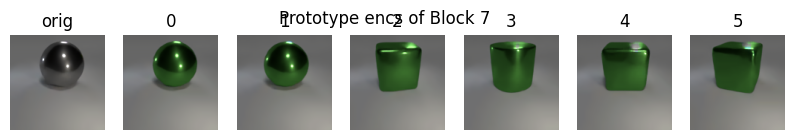

In [91]:
# ig, axs = plt.subplots(1,2,figsize=(10, 10))
# axs = axs.flatten()

# axs[0].imshow(torch_img_to_np_img(out1))
# axs[0].set_title('decode1')
# axs[0].axis('off')

# axs[1].imshow(torch_img_to_np_img(out2))
# axs[1].set_title('prototypes')
# axs[1].axis('off')

fig, axs = plt.subplots(1, n_cluster+1, figsize=(10, 1.5))
axs = axs.flatten()

axs[0].imshow(torch_img_to_np_img(out1))
axs[0].set_title('orig')
axs[0].axis('off')

for cluster_id in range(n_cluster):
    axs[cluster_id+1].imshow(torch_img_to_np_img(out_prototypes_block[cluster_id]))
    axs[cluster_id+1].set_title(f'{cluster_id}')
    axs[cluster_id+1].axis('off')

fig.suptitle(f'Prototype encs of Block {block_id}');
fig.savefig(f'tmp/prototypes_{block_id}.png')

In [90]:
n_cluster

6